# Time-Series MIA Example 
Base of example. Use and build upon this notebook during development.

In [1]:
import os
import sys
import yaml
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import ECGDataset, preprocess_ECG_dataset, get_ECG_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.TimesNet import TimesNet
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.TFT import TFT

In [2]:
# Define constants
lookback = 100
horizon = 20
num_individuals = 10
train_fraction = 0.3
test_fraction = 0.3
epochs = 1

In [3]:
# Get data loaders
path = os.path.join(os.getcwd(), "data")
dataset = preprocess_ECG_dataset(path, lookback, horizon, num_individuals)
train_loader, test_loader = get_ECG_dataloaders(dataset, train_fraction, test_fraction)

In [4]:
# Load the config.yaml file
with open('audit.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Train the LSTM model
input_dim = 12 # input size will be the amount of variables in the Time-Series

if config["target"]["model_class"] == "LSTM":
    model = LSTM(input_dim, horizon)
elif config["target"]["model_class"] == "TCN":
    model = TCN(input_dim, horizon)
elif config["target"]["model_class"] == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif config["target"]["model_class"] == "TimesNet":
    model = TimesNet(input_dim, lookback, horizon)
elif config["target"]["model_class"] == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif config["target"]["model_class"] == "TFT":
    model = TFT(input_dim, lookback, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs)

Training Progress: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


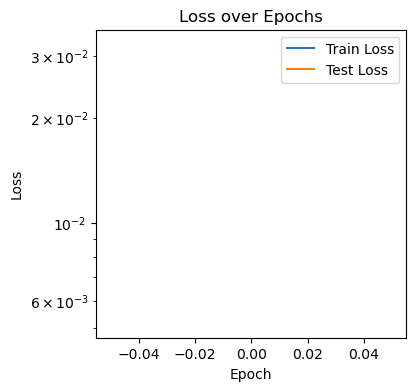

In [5]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [6]:
from ECG_handler import ECGInputHandler
from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(ECGInputHandler, config_path)

# Run the audit 
leakpro.run_audit()

2025-02-21 16:36:28,544 INFO     Target model blueprint created from DLinear in ./utils/models/DLinear.py.
2025-02-21 16:36:28,563 INFO     Loaded target model metadata from ./target/model_metadata.pkl
2025-02-21 16:36:28,594 INFO     Loaded target model from ./target


{'audit': {'random_seed': 42, 'attack_list': {}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'time_series'}, 'target': {'module_path': './utils/models/DLinear.py', 'model_class': 'DLinear', 'target_folder': './target', 'data_path': './data/ECG.pkl'}, 'shadow_model': None, 'distillation_model': None}


2025-02-21 16:36:28,862 INFO     Loaded population dataset from ./data/ECG.pkl
2025-02-21 16:36:28,862 INFO     Loaded population dataset from ./data/ECG.pkl
2025-02-21 16:36:30,261 INFO     MIA attack factory loaded.
2025-02-21 16:36:30,261 INFO     Auditing completed


### Testing signals

In [7]:
from numpy import mean
print(f'Avg train MSE:', mean(train_loss))
print(f'Avg test MSE:', mean(test_loss))

Avg train MSE: 0.0325107633723351
Avg test MSE: 0.005152710798479941


In [8]:
from torch.nn import MSELoss
from leakpro.signals.signal import SeasonalityLoss, TrendLoss
from leakpro.signals.signal_extractor import PytorchModel

pmodel = PytorchModel(model, MSELoss)

seasonality_signal = SeasonalityLoss()
train_sloss = seasonality_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_sloss = seasonality_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

trend_signal = TrendLoss()
train_tloss = trend_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_tloss = trend_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

print(f'Mean train seasonality loss:', mean(train_sloss))
print(f'Mean test seasonality loss:', mean(test_sloss))

print(f'Mean train trend loss:', mean(train_tloss))
print(f'Mean test trend loss:', mean(test_tloss))

Getting trend loss for model 1/ 1: 100%|██████████| 458/458 [00:00<00:00, 458.41it/s]

Mean train seasonality loss: 11.173053724042914
Mean test seasonality loss: 11.876450869767185
Mean train trend loss: 1.6149130569969037
Mean test trend loss: 1.8052093764270796


In [11]:
from leakpro.signals.signal import TS2VecLoss
ts2vec_signal = TS2VecLoss()
train_tsvloss = ts2vec_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_tsvloss = ts2vec_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

print(f'Mean train ts2vec loss:', mean(train_tsvloss))
print(f'Mean test ts2vec loss:', mean(test_tsvloss))

Getting TS2Vec loss for model 1/ 1: 100%|██████████| 458/458 [00:22<00:00, 20.54it/s]

Mean train ts2vec loss: 0.6711365
Mean test ts2vec loss: 0.61968374
